In [1]:
import torch
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
import numpy
from torch.utils.data import Dataset,DataLoader
import os
import zipfile as zip
import glob
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import zipfile
import random
import shutil
from shutil import copyfile
import torchvision

In [2]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2022-04-20 07:53:56--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.220.188.106, 2600:1402:6800:2a7::e59, 2600:1402:6800:283::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.220.188.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M   219MB/s    in 3.6s    

2022-04-20 07:54:00 (218 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [3]:

print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

12501
12501


In [4]:
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

In [5]:

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [6]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

11250
11250
1250
1250


In [7]:
TRAINING_DIR = "/tmp/cats-v-dogs/training/"
VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"

In [8]:

train_transforms =  transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
])

val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
])


In [9]:
training_data = ImageFolder("/tmp/cats-v-dogs/training",transform=train_transforms)
validation_data = ImageFolder("/tmp/cats-v-dogs/testing",transform=val_transforms)

In [10]:
training_data.classes,validation_data.classes

(['cats', 'dogs'], ['cats', 'dogs'])

In [11]:
training_data.class_to_idx,validation_data.class_to_idx

({'cats': 0, 'dogs': 1}, {'cats': 0, 'dogs': 1})

In [12]:
training_data_loader = DataLoader(training_data,batch_size=100,shuffle=True)
validation_data_loader = DataLoader(validation_data,batch_size=100,shuffle=True)

In [13]:
inputs_batch, labels_batch = next(iter(training_data_loader))
grid = torchvision.utils.make_grid(inputs_batch, nrow=40, pad_value=1)
torchvision.utils.save_image(grid, 'inputs_batch_preview.png')

In [14]:
config = [
     # input_channels:int,no.of filters:int,filter_size:int,stride:int,padding:int
     (3,16,3,2,0),
     # MP - max pooling:string,filter_size:int,stride:int,padding:int
     ("MP",2,2,0),
     (16,32,3,2,0),
     ("MP",2,2,0),
     (32,64,3,2,0),
     ("MP",2,2,0)
]

In [15]:
def conv_output_size(img_size,padding,filter_size,stride,n_filters):
   size_ = (int((img_size + (2 * padding) - filter_size) / stride)) + 1
   return size_,size_,n_filters

In [16]:

def dense_layer_size(configuration,img_size):

  _,output_channels = 0,0
  layer_count = 0

  for config in configuration:
    
    layer_count += 1

    if config[0] == "MP":
      img_size,_,output_channels = conv_output_size(img_size,config[3],config[1],config[2],output_channels)
      print("Max Pooling Layer {} output dims :: ".format(layer_count),img_size,_,output_channels)

    else: 
      img_size,_,output_channels = conv_output_size(img_size,config[4],config[2],config[3],config[1])
      print("Conv Layer {} output dims :: ".format(layer_count),img_size,_,output_channels)
  
  return img_size,_,output_channels

In [17]:
width,heigth,channels = dense_layer_size(config,224)

Conv Layer 1 output dims ::  111 111 16
Max Pooling Layer 2 output dims ::  55 55 16
Conv Layer 3 output dims ::  27 27 32
Max Pooling Layer 4 output dims ::  13 13 32
Conv Layer 5 output dims ::  6 6 64
Max Pooling Layer 6 output dims ::  3 3 64


In [18]:
width * heigth * channels

576

In [19]:
class NeuralNetwork(nn.Module):

  def __init__(self):
    super(NeuralNetwork,self).__init__()

    self.layer1 = nn.Sequential(
        nn.Conv2d(3,16,3,2,0),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Dropout2d(p=0.25)
    )

    self.layer2 = nn.Sequential(
        nn.Conv2d(16,32,3,2,0),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Dropout2d(p=0.25)
    )

    self.layer3 = nn.Sequential(
        nn.Conv2d(32,64,3,2,0),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Dropout2d(p=0.25)
    )

    self.FC = nn.Sequential(
        nn.Linear(576,512),
        nn.ReLU(),
        nn.Dropout(p=0.5),

        nn.Linear(512,2),
    )    

  def forward(self,x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)

    x = x.view(x.size(0),-1)
    x = self.FC(x)

    return x

In [20]:

net = NeuralNetwork()
optimizer = torch.optim.Adam(net.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

net.train()

NeuralNetwork(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.25, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.25, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.25, inplace=False)
  )
  (FC): Sequential(
    (0): Lin

In [21]:
epochs = 30

training_acc = []
training_loss = []

val_acc = []
val_loss = []

for epoch in range(epochs):

  epoch_acc = 0
  epoch_loss = 0

  for batch_id,(image,label) in enumerate(training_data_loader):

    output = net(image)

    loss = criterion(output,label)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    acc = (output.argmax(dim=1) == label).float().mean()
    epoch_acc += acc.item() / len(training_data_loader) 
    epoch_loss += loss.item() / len(training_data_loader)

  print(f"Epoch [{epoch + 1}/{epochs}] Training Accuracy :: {epoch_acc:.4f} Training Loss :: {epoch_loss:.4f}")
  
  training_acc.append(epoch_acc)
  training_loss.append(epoch_loss)

  with torch.no_grad():

    epoch_val_acc = 0
    epoch_val_loss = 0

    for batch_id,(image,label) in enumerate(validation_data_loader):

      output = net(image)
      loss = criterion(output,label)

      acc = (output.argmax(dim=1) == label).float().mean()
      epoch_val_acc += acc.item() / len(validation_data_loader) 
      epoch_val_loss += loss.item() / len(validation_data_loader)

    print(f"Epoch [{epoch + 1}/{epochs}] Val Accuracy :: {epoch_val_acc:.4f} Val Loss :: {epoch_val_loss:.4f}")
    val_acc.append(epoch_val_acc)
    val_loss.append(epoch_val_loss)


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

Epoch [1/30] Training Accuracy :: 0.6265 Training Loss :: 0.6418
Epoch [1/30] Val Accuracy :: 0.6612 Val Loss :: 0.6162
Epoch [2/30] Training Accuracy :: 0.6848 Training Loss :: 0.5878
Epoch [2/30] Val Accuracy :: 0.7116 Val Loss :: 0.5635
Epoch [3/30] Training Accuracy :: 0.7127 Training Loss :: 0.5550
Epoch [3/30] Val Accuracy :: 0.7292 Val Loss :: 0.5499
Epoch [4/30] Training Accuracy :: 0.7279 Training Loss :: 0.5363
Epoch [4/30] Val Accuracy :: 0.7424 Val Loss :: 0.5266
Epoch [5/30] Training Accuracy :: 0.7442 Training Loss :: 0.5155
Epoch [5/30] Val Accuracy :: 0.7460 Val Loss :: 0.5127
Epoch [6/30] Training Accuracy :: 0.7537 Training Loss :: 0.5046
Epoch [6/30] Val Accuracy :: 0.7588 Val Loss :: 0.4937
Epoch [7/30] Training Accuracy :: 0.7618 Training Loss :: 0.4896
Epoch [7/30] Val Accuracy :: 0.7572 Val Loss :: 0.4928
Epoch [8/30] Training Accuracy :: 0.7747 Training Loss :: 0.4760
Epoch [8/30] Val Accuracy :: 0.7628 Val Loss :: 0.4980
Epoch [9/30] Training Accuracy :: 0.7760

In [22]:
torch.save(net.state_dict(),"cat_vs_dog.pt")

In [23]:
import matplotlib.pyplot as plt

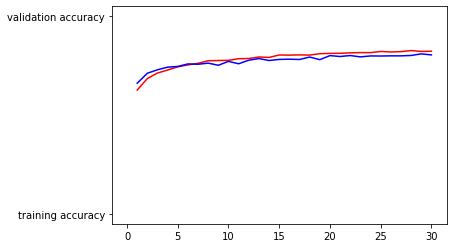

In [25]:
epochs_ = list(range(1,31))

plt.plot(epochs_,training_acc,'r',"training accuracy")
plt.plot(epochs_,val_acc,"b","validation accuracy")

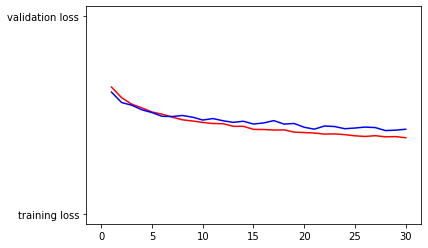

In [26]:
epochs_ = list(range(1,31))

plt.plot(epochs_,training_loss,'r',"training loss")
plt.plot(epochs_,val_loss,"b","validation loss")

In [27]:
data_transformation = transforms.Compose([
              transforms.Resize((224,224)),
              transforms.ToTensor()
])

In [28]:
net.eval()

NeuralNetwork(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.25, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.25, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.25, inplace=False)
  )
  (FC): Sequential(
    (0): Lin

In [29]:
image_path = "/content/sacat.jpg" 

image = Image.open(image_path)
image = data_transformation(image)


predictions = net(image[None,...])
print(predictions.argmax(dim=1))

tensor([0])
